In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn

In [4]:
torch.manual_seed(7)

In [6]:
df = pd.read_csv('apple_share_price.csv', usecols=[1, 2, 3, 4])  # Open, High, Low, Close
df = df.iloc[::-1]  # Reverse dataset (most recent last)

In [8]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values) 

In [10]:
def create_sequences(data, step_size=20):
    X, Y = [], []
    for i in range(len(data) - step_size):
        X.append(data[i:i+step_size])
        Y.append(data[i+step_size][3])  # Use Close price as label
    return np.array(X), np.array(Y)

step_size = 20
X, y = create_sequences(scaled_data, step_size)

In [12]:
train_size = int(len(X) * 0.75)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [14]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=4, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Use output from last time step
        out = self.fc(out)
        return out

model = LSTMModel()

In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
print("\nTraining model...\n")
for epoch in range(100):
    model.train()
    output = model(X_train).squeeze()
    loss = criterion(output, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.5f}")


Training model...

Epoch 10, Loss: 0.04160
Epoch 20, Loss: 0.02433
Epoch 30, Loss: 0.01089
Epoch 40, Loss: 0.00400
Epoch 50, Loss: 0.00239
Epoch 60, Loss: 0.00149
Epoch 70, Loss: 0.00119
Epoch 80, Loss: 0.00095
Epoch 90, Loss: 0.00086
Epoch 100, Loss: 0.00079


In [20]:
model.eval()
train_preds = model(X_train).detach().numpy()
test_preds = model(X_test).detach().numpy()

In [22]:
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[3], scaler.scale_[3]
train_preds_real = close_scaler.inverse_transform(train_preds)
test_preds_real = close_scaler.inverse_transform(test_preds)
y_train_real = close_scaler.inverse_transform(y_train.view(-1, 1).detach().numpy())
y_test_real = close_scaler.inverse_transform(y_test.view(-1, 1).detach().numpy())

In [24]:
train_rmse = np.sqrt(mean_squared_error(y_train_real, train_preds_real))
test_rmse = np.sqrt(mean_squared_error(y_test_real, test_preds_real))
print(f"\nTrain RMSE: {train_rmse:.2f}")
print(f"Test RMSE:  {test_rmse:.2f}")


Train RMSE: 2.76
Test RMSE:  5.08


In [26]:
r2_train = r2_score(y_train_real, train_preds_real)
r2_test = r2_score(y_test_real, test_preds_real)
print(f"Train R² Score: {r2_train:.4f}")
print(f"Test R² Score:  {r2_test:.4f}")

Train R² Score: 0.9873
Test R² Score:  0.9366


In [28]:
def within_percent(actual, predicted, percent=5):
    threshold = actual * (percent / 100)
    correct = np.abs(predicted - actual) <= threshold
    return np.mean(correct) * 100

train_acc = within_percent(y_train_real, train_preds_real)
test_acc = within_percent(y_test_real, test_preds_real)
print(f"Train Accuracy (±5%): {train_acc:.2f}%")
print(f"Test Accuracy  (±5%): {test_acc:.2f}%")

Train Accuracy (±5%): 83.78%
Test Accuracy  (±5%): 80.78%


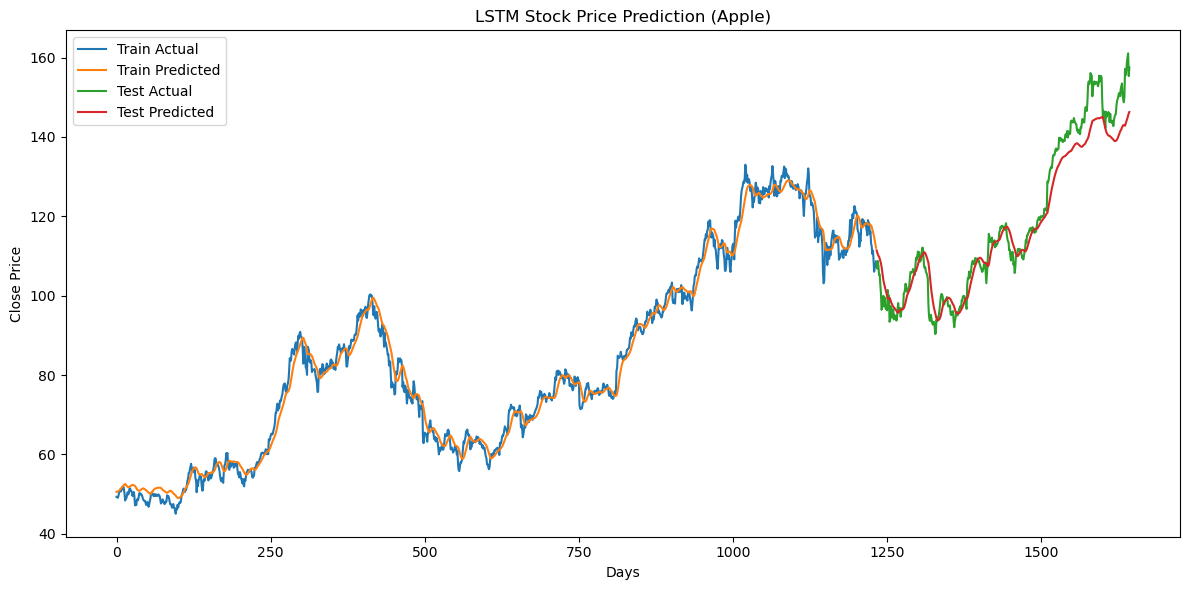

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_train_real)), y_train_real, label='Train Actual')
plt.plot(np.arange(len(train_preds_real)), train_preds_real, label='Train Predicted')
plt.plot(np.arange(len(y_train_real), len(y_train_real) + len(y_test_real)), y_test_real, label='Test Actual')
plt.plot(np.arange(len(train_preds_real), len(train_preds_real) + len(test_preds_real)), test_preds_real, label='Test Predicted')
plt.xlabel("Days")
plt.ylabel("Close Price")
plt.title("LSTM Stock Price Prediction (Apple)")
plt.legend()
plt.tight_layout()
plt.show()